In [ ]:
!pip install transformer_lens

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.0/192.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
  

In [ ]:
from transformer_lens import HookedTransformer
from transformer_lens.hook_points import HookPoint
import einops
import numpy as np
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set()

MODEL_NAME = 'gpt2-small'
SHORT_PROMPT = "The sale ends today. You won't want to miss it!"
LONG_PROMPT = "There once was a traveler named Joe who had been to every country in the world. He kept a journal of his adventures. He knew many languages and had tried many different cuisines. When Joe reached the old age of 96, he died. The end."

model: HookedTransformer = HookedTransformer.from_pretrained("gpt2-small")
model.to_str_tokens("Good morning"), model.to_tokens("Good morning")

Loaded pretrained model gpt2-small into HookedTransformer


(['<|endoftext|>', 'Good', ' morning'], tensor([[50256, 10248,  3329]]))

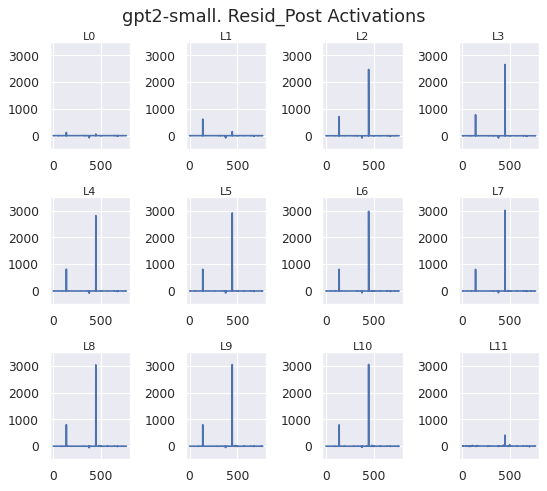

In [ ]:
acts = []
def hook(activation, hook: HookPoint):
    acts.append(activation[0].detach().numpy())
filter = lambda name: name.endswith("resid_post")
model.run_with_hooks(
    [''],
    return_type=None,
    fwd_hooks=[(filter, hook)],
)

# Assume `data` has shape (N, T)
n_rows = (len(acts) + 2) // 4  # 4 columns
fig, axes = plt.subplots(n_rows, 4, figsize=(7, 2 * n_rows), dpi=80)
axes = axes.flatten()  # flatten in case of a single row

pos = 0
for i, act in enumerate(acts):
    ax = axes[i]
    ax.plot(act[pos])
    ax.set_title(f"L{i}", fontsize=10, pad=2)
    ax.set_ylim(-500, 3500)

# Remove any empty subplots
for j in range(len(acts), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
fig.suptitle(f'{MODEL_NAME}. Resid_Post Activations', fontsize=16, y=1.02)
plt.show()

In [ ]:
MASSIVE_ACT_DIM = np.where(acts[5][0]>1000)[0][0]
print(f"massive act: {MASSIVE_ACT_DIM}")

massive act: 447


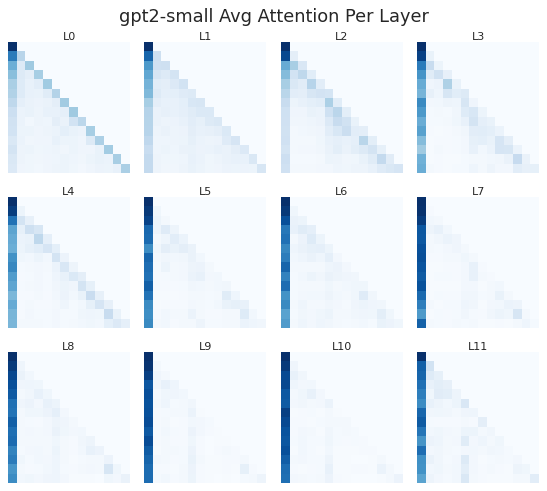

In [ ]:
acts = []
def hook(activation, hook: HookPoint):
    acts.append(activation[0].detach().numpy())
filter = lambda name: name.endswith("attn.hook_pattern")
model.run_with_hooks(
    [SHORT_PROMPT],
    return_type=None,
    fwd_hooks=[(filter, hook)],
)

n_rows = (len(acts) + 2) // 4
fig, axes = plt.subplots(n_rows, 4, figsize=(7, 2 * n_rows), dpi=80)
axes = axes.flatten()

pos = 0
for i, act in enumerate(acts):
    ax = axes[i]
    im = ax.imshow(acts[i].mean(0), aspect='auto', cmap='Blues', vmin=0, vmax=1)
    ax.set_title(f"L{i}", fontsize=10, pad=2)
    ax.axis('off')

for j in range(len(acts), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
fig.suptitle(f'{MODEL_NAME} Avg Attention Per Layer', fontsize=16, y=1.02)
plt.show()

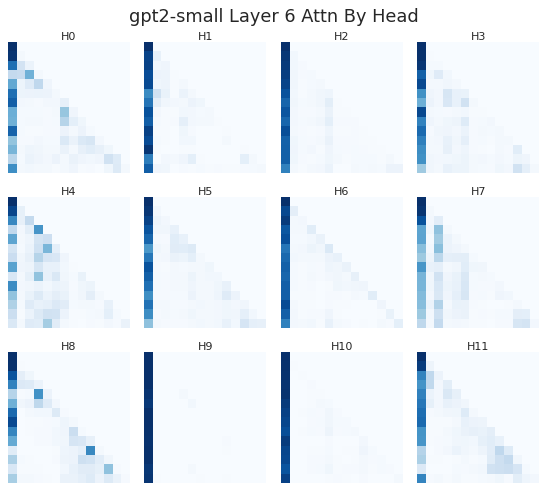

In [ ]:
acts = []
def hook(activation, hook: HookPoint):
    acts.append(activation[0].detach().numpy())
filter = lambda name: name.endswith("attn.hook_pattern")
model.run_with_hooks(
    [SHORT_PROMPT],
    return_type=None,
    fwd_hooks=[(filter, hook)],
)

layer_view = 6
num_heads = acts[layer_view].shape[0]
n_rows = (num_heads + 2) // 4
fig, axes = plt.subplots(n_rows, 4, figsize=(7, 2 * n_rows), dpi=80)
axes = axes.flatten()

pos = 0
for i in range(num_heads):
    ax = axes[i]
    im = ax.imshow(acts[layer_view][i], aspect='auto', cmap='Blues', vmin=0, vmax=1)
    ax.set_title(f"H{i}", fontsize=10, pad=2)
    ax.axis('off')

# Remove any empty subplots
for j in range(len(acts), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
fig.suptitle(f"{MODEL_NAME} Layer {layer_view} Attn By Head", fontsize=16, y=1.02)
plt.show()

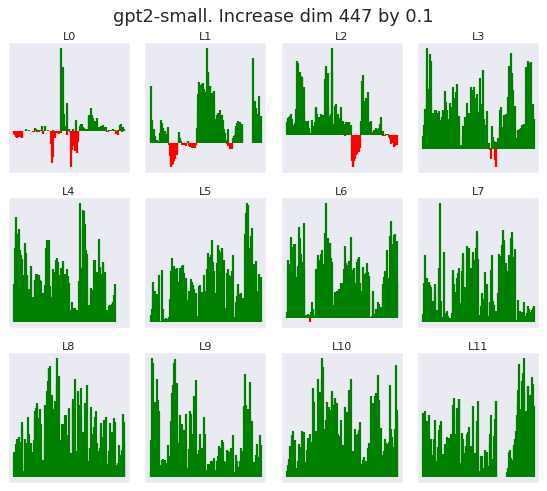

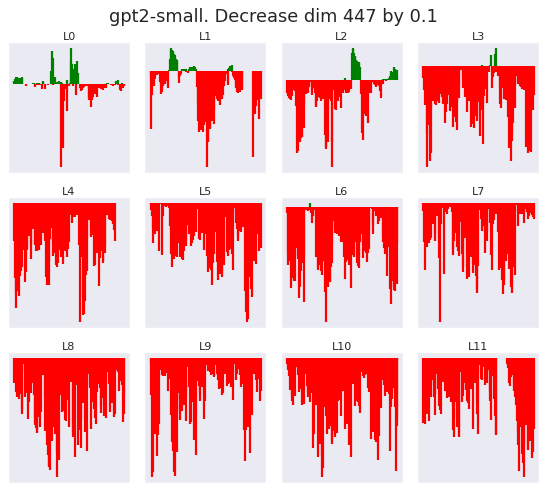

In [ ]:
#try incrementing MASSIVE_ACT_DIM slightly in residual stream, then measure impact in next attention layer.
acts_base = []
q_base = []
k_base = []
def hook(activation, hook: HookPoint):
  if hook.name.endswith("attn.hook_pattern"):
    acts_base.append(activation[0, :, :, 0].detach().numpy())
  elif hook.name.endswith("hook_k"):
    k_base.append(activation[0, 0, :, :].detach().numpy())
  else:
    q_base.append(activation[0, :, :, :].detach().numpy())

filter = lambda name: name.endswith("attn.hook_pattern") or name.endswith(f"attn.hook_q") or name.endswith(f"attn.hook_k")
model.run_with_hooks(
    [SHORT_PROMPT],
    return_type=None,
    fwd_hooks=[(filter, hook)],
)

acts_up = []
k_up = []
def hook(activation, hook: HookPoint):
    if hook.name.endswith("attn.hook_pattern"):
      acts_up.append(activation[0, :, :, 0].detach().numpy())
    elif hook.name.endswith("hook_normalized"):
      activation[0,0,MASSIVE_ACT_DIM] += 0.1
    else:
      k_up.append(activation[0, 0, :, :].detach().numpy())

for i in range(model.cfg.n_layers):
  full_filter = lambda name: name.endswith(f"blocks.{i}.attn.hook_pattern") or name.endswith(f"blocks.{i}.ln1.hook_normalized") or name.endswith(f"blocks.{i}.attn.hook_k")
  model.run_with_hooks(
      [SHORT_PROMPT],
      return_type=None,
      fwd_hooks=[(full_filter, hook)],
  )

acts_down = []
k_down = []
def hook(activation, hook: HookPoint):
    if hook.name.endswith("attn.hook_pattern"):
      acts_down.append(activation[0, :, :, 0].detach().numpy())
    elif hook.name.endswith("hook_normalized"):
      activation[0,0,MASSIVE_ACT_DIM] -= 0.1
    else:
      k_down.append(activation[0, 0, :, :].detach().numpy())

for i in range(model.cfg.n_layers):
  full_filter = lambda name: name.endswith(f"blocks.{i}.attn.hook_pattern") or name.endswith(f"blocks.{i}.ln1.hook_normalized") or name.endswith(f"blocks.{i}.attn.hook_k")
  model.run_with_hooks(
      [SHORT_PROMPT],
      return_type=None,
      fwd_hooks=[(full_filter, hook)],
  )

acts = [(acts_up[i]-acts_base[i]).flatten() for i in range(model.cfg.n_layers)]

n_rows = (len(acts) + 2) // 4
fig, axes = plt.subplots(n_rows, 4, figsize=(7, 2 * n_rows), dpi=80)
axes = axes.flatten()

for i, act in enumerate(acts):
    ax = axes[i]
    ax.set_title(f"L{i}", fontsize=10, pad=2)
    for i, y in enumerate(act):
      color = 'green' if y >= 0 else 'red'
      ax.vlines(x=i, ymin=0, ymax=y, color=color, linewidth=2)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
# Remove any empty subplots
for j in range(len(acts), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
fig.suptitle(f"{MODEL_NAME}. Increase dim {MASSIVE_ACT_DIM} by 0.1", fontsize=16, y=1.02)
plt.show()

acts = [(acts_down[i]-acts_base[i]).flatten() for i in range(model.cfg.n_layers)]

n_rows = (len(acts) + 2) // 4
fig, axes = plt.subplots(n_rows, 4, figsize=(7, 2 * n_rows), dpi=80)
axes = axes.flatten()

for i, act in enumerate(acts):
    ax = axes[i]
    ax.set_title(f"L{i}", fontsize=10, pad=2)
    for i, y in enumerate(act):
      color = 'green' if y >= 0 else 'red'
      ax.vlines(x=i, ymin=0, ymax=y, color=color, linewidth=2)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# Remove any empty subplots
for j in range(len(acts), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
fig.suptitle(f"{MODEL_NAME}. Decrease dim {MASSIVE_ACT_DIM} by 0.1", fontsize=16, y=1.02)
plt.show()

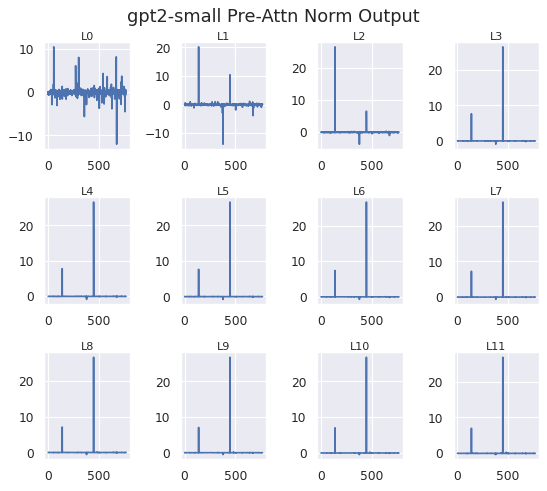

In [ ]:
acts = []
processed_hooks = []
def hook(activation, hook: HookPoint):
    if hook.name not in processed_hooks:
      acts.append(activation[0].detach().numpy())
    processed_hooks.append(hook.name)
filter = lambda name: name.endswith('ln1.hook_normalized')
model.run_with_hooks(
    [SHORT_PROMPT],
    return_type=None,
    fwd_hooks=[(filter, hook)],
)

n_rows = (len(acts) + 2) // 4
fig, axes = plt.subplots(n_rows, 4, figsize=(7, 2 * n_rows), dpi=80)
axes = axes.flatten()

pos = 0
for i, act in enumerate(acts):
    ax = axes[i]
    ax.plot(act[pos])
    ax.set_title(f"L{i}", fontsize=10, pad=2)

# Remove any empty subplots
for j in range(len(acts), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
fig.suptitle(f"{MODEL_NAME} Pre-Attn Norm Output", fontsize=16, y=1.02)
plt.show()

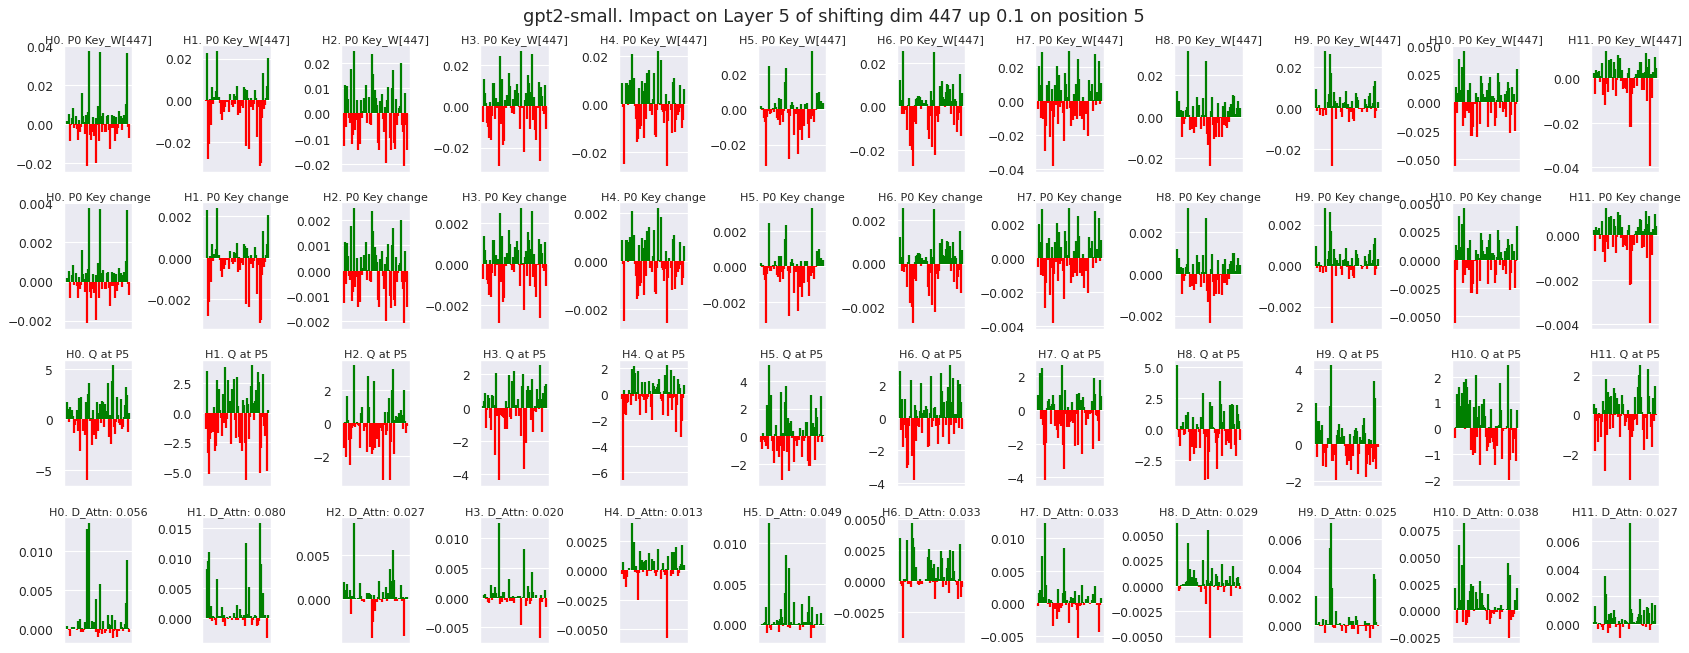

In [ ]:
position=5
layer = 5

qs = []
def hook(activation, hook: HookPoint):
    qs.append(activation[0].detach().numpy())
filter = lambda name: name.endswith(f"blocks.{layer}.attn.hook_q")
model.run_with_hooks(
    [SHORT_PROMPT],
    return_type=None,
    fwd_hooks=[(filter, hook)],
)
qs = qs[0][position]

for n,v in model.named_parameters():
  if n==f'blocks.{layer}.attn.W_K':
    break
weights = v.detach()[:,MASSIVE_ACT_DIM,:]
acts = k_up[layer]-k_base[layer]
impact = acts*qs

acts = np.concatenate([weights, acts, qs, impact])

n_cols=12
n_rows = (len(acts) + 2) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(21, 2 * n_rows), dpi=80)
axes = axes.flatten()
for i, act in enumerate(acts):
    ax = axes[i]
    if i<12:
      ax.set_title(f"H{i%12}. P0 Key_W[{MASSIVE_ACT_DIM}]", fontsize=10, pad=2)
    elif i<24:
      ax.set_title(f"H{i%12}. P0 Key change", fontsize=10, pad=2)
    elif i<36:
      ax.set_title(f"H{i%12}. Q at P5", fontsize=10, pad=2)
    else:
      total = sum(act)
      ax.set_title(f"H{i%12}. D_Attn: {total:.3f}", fontsize=10, pad=2)
    for i, y in enumerate(act):
      color = 'green' if y >= 0 else 'red'
      ax.vlines(x=i, ymin=0, ymax=y, color=color, linewidth=2)
    ax.get_xaxis().set_visible(False)

# Remove any empty subplots
for j in range(len(acts), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
fig.suptitle(f"{MODEL_NAME}. Impact on Layer {layer} of shifting dim {MASSIVE_ACT_DIM} up 0.1 on position {position}", fontsize=16, y=1.02)
plt.show()

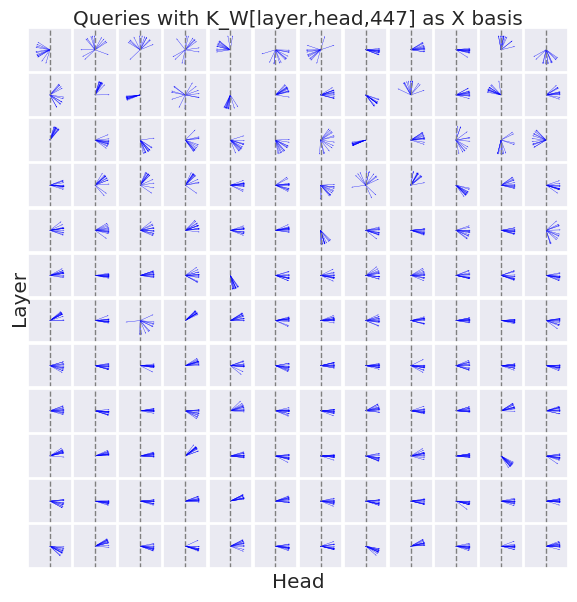

In [ ]:
def get_param(name):
  found=False
  for n,v in model.named_parameters():
    if n==name:
      found = True
      break
  assert found
  return v.detach().numpy()

def plot_2d_vectors_in_subplot(vectors, row, col, rows, cols, fig=None, axs=None, color='blue'):
    ax = axs[row][col]
    origin = np.zeros((2, len(vectors)))
    vectors = np.array(vectors).T  # shape: (2, N)

    ax.quiver(*origin, *vectors, angles='xy', scale_units='xy', scale=1, color=color)
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axvline(x=0, linestyle='--', color='gray', linewidth=1)
    return fig, axs

def rotation_matrix_to_first_axis_nd(x):
    """
    Generalized method for any dimension using Householder reflection
    Rotates vector x to align with the first standard basis vector [1,0,0,...,0]

    Args:
        x: N-dimensional vector (numpy array or list)

    Returns:
        NxN rotation matrix (numpy array)
    """
    x = np.array(x, dtype=float)
    n = len(x)

    # Normalize the input vector
    norm = np.linalg.norm(x)
    if norm == 0:
        raise ValueError("Cannot rotate zero vector")

    u = x / norm

    # Create target vector (first standard basis vector)
    target = np.zeros(n)
    target[0] = 1.0

    # Handle special cases
    dot_product = np.dot(u, target)
    if np.isclose(dot_product, 1.0):
        # Already aligned
        return np.eye(n)
    elif np.isclose(dot_product, -1.0):
        # Opposite direction - need 180° rotation
        # Use reflection across hyperplane perpendicular to first axis
        R = np.eye(n)
        R[0, 0] = -1
        return R

    # General case: Use Householder reflection
    # Find vector that when reflected maps u to target
    # We want to reflect u to target, so we find the reflection vector

    # Method 1: Direct Householder to map u to target
    # The reflection vector is: v = (u - target) / ||u - target||
    v = u - target
    v = v / np.linalg.norm(v)

    # Householder reflection matrix: H = I - 2vv^T
    H = np.eye(n) - 2 * np.outer(v, v)

    return H

qs = []
ks = []
def hook(activation, hook: HookPoint):
  if hook.name.endswith("hook_k"):
    ks.append(activation[0, 0, :, :].detach().numpy())
  else:
    qs.append(activation[0, :, :, :].detach().numpy())
filter = lambda name: name.endswith(f"attn.hook_q") or name.endswith(f"attn.hook_k")
model.run_with_hooks(
    [SHORT_PROMPT],
    return_type=None,
    fwd_hooks=[(filter, hook)],
)

rows, cols = model.cfg.n_layers, model.cfg.n_heads
fig, axs = plt.subplots(rows, cols, figsize=(6,6))
layer_5_rotations = []
for layer in range(model.cfg.n_layers):
  for head in range(model.cfg.n_heads):
    k = ks[layer][head]
    k = get_param(f'blocks.{layer}.attn.W_K')[head,MASSIVE_ACT_DIM]
    R_hd = rotation_matrix_to_first_axis_nd(k)
    rotated_k = R_hd @ k
    rotated_k_2d = [rotated_k[0],rotated_k[1]]
    if layer==5:
      layer_5_rotations.append(R_hd)
    rotated_qs_2d = []
    qs_at_pos = qs[layer][1:,head]
    for q in qs_at_pos:
      rotated_q = R_hd @ q
      q1, q2 = rotated_q[0], rotated_q[1]
      norm = (q1**2+q2**2)**0.5
      rotated_qs_2d.append([q1/norm, q2/norm])
    plot_2d_vectors_in_subplot(rotated_qs_2d, layer, head, model.cfg.n_layers, model.cfg.n_heads, fig=fig, axs=axs)
plt.tight_layout(pad=0.1)
fig.subplots_adjust(top=0.95, left=0.05, bottom=0.05, right=0.95)
fig.suptitle(f'Queries with K_W[layer,head,{MASSIVE_ACT_DIM}] as X basis')
fig.supxlabel('Head')
fig.supylabel('Layer')
plt.show()

In [ ]:
weights.shape

torch.Size([12, 64])

In [ ]:
rotation_tensor = np.stack(layer_5_rotations)  # Shape: (2, 3)
rotation_tensor = t.from_numpy(rotation_tensor).float()

In [ ]:
x = rotation_tensor@weights.transpose(0,1)
x.shape, weights.shape

(torch.Size([12, 64, 12]), torch.Size([12, 64]))

In [ ]:
weights.shape

torch.Size([12, 64])

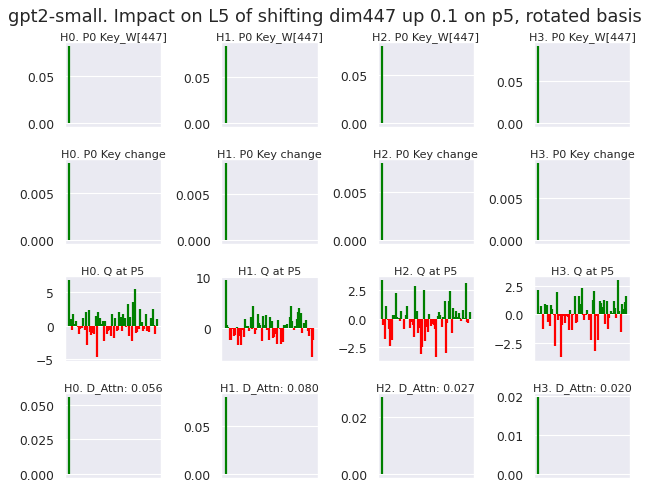

In [ ]:
position=5
layer = 5

qs = []
def hook(activation, hook: HookPoint):
    qs.append(activation[0].detach().numpy())
filter = lambda name: name.endswith(f"blocks.{layer}.attn.hook_q")
model.run_with_hooks(
    [SHORT_PROMPT],
    return_type=None,
    fwd_hooks=[(filter, hook)],
)
qs = qs[0][position]

for n,v in model.named_parameters():
  if n==f'blocks.{layer}.attn.W_K':
    break
weights = v.detach()[:,MASSIVE_ACT_DIM,:]
acts = k_up[layer]-k_base[layer]
impact = acts*qs

fig, axes = plt.subplots(4, 4, figsize=(8,6), dpi=80)
axes = axes.flatten()
for head in range(4):
  w = layer_5_rotations[head]@weights[head].numpy()
  a = layer_5_rotations[head]@acts[head]
  q = layer_5_rotations[head]@qs[head]
  impact = a*q
  data = [w,a,q,impact]
  for row in range(4):
    ax = axes[row*4+head]
    if row==0:
      ax.set_title(f"H{head}. P0 Key_W[{MASSIVE_ACT_DIM}]", fontsize=10, pad=2)
    elif row==1:
      ax.set_title(f"H{head}. P0 Key change", fontsize=10, pad=2)
    elif row==2:
      ax.set_title(f"H{head}. Q at P5", fontsize=10, pad=2)
    else:
      total = sum(data[row])
      ax.set_title(f"H{head}. D_Attn: {total:.3f}", fontsize=10, pad=2)
    for i, y in enumerate(data[row]):
      color = 'green' if y >= 0 else 'red'
      ax.vlines(x=i, ymin=0, ymax=y, color=color, linewidth=2)
    ax.get_xaxis().set_visible(False)

plt.tight_layout()
fig.suptitle(f"{MODEL_NAME}. Impact on L{layer} of shifting dim{MASSIVE_ACT_DIM} up 0.1 on p{position}, rotated basis", fontsize=16, y=1.02)
plt.show()

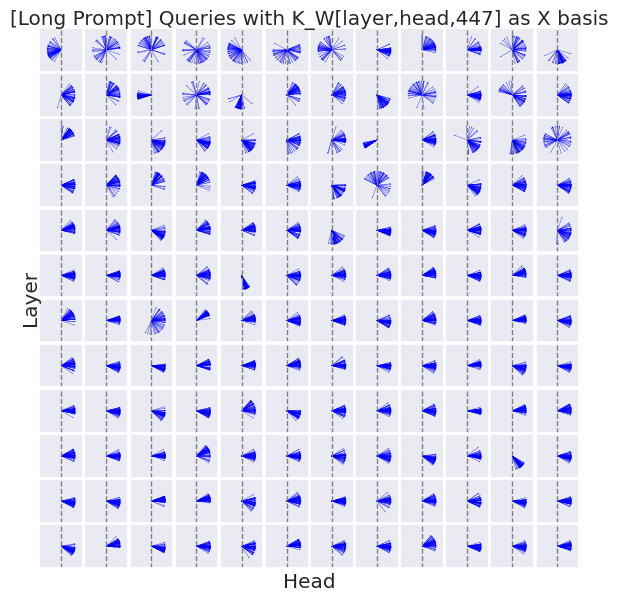

In [ ]:
qs = []
ks = []
def hook(activation, hook: HookPoint):
  if hook.name.endswith("hook_k"):
    ks.append(activation[0, 0, :, :].detach().numpy())
  else:
    qs.append(activation[0, :, :, :].detach().numpy())
filter = lambda name: name.endswith(f"attn.hook_q") or name.endswith(f"attn.hook_k")
model.run_with_hooks(
    [LONG_PROMPT],
    return_type=None,
    fwd_hooks=[(filter, hook)],
)

rows, cols = model.cfg.n_layers, model.cfg.n_heads
fig, axs = plt.subplots(rows, cols, figsize=(6,6))

for layer in range(model.cfg.n_layers):
  for head in range(model.cfg.n_heads):
    k = ks[layer][head]
    k = get_param(f'blocks.{layer}.attn.W_K')[head,MASSIVE_ACT_DIM]
    R_hd = rotation_matrix_to_first_axis_nd(k)
    rotated_k = R_hd @ k
    rotated_k_2d = [rotated_k[0],rotated_k[1]]

    rotated_qs_2d = []
    qs_at_pos = qs[layer][1:,head]
    for q in qs_at_pos:
      rotated_q = R_hd @ q
      q1, q2 = rotated_q[0], rotated_q[1]
      norm = (q1**2+q2**2)**0.5
      rotated_qs_2d.append([q1/norm, q2/norm])
    plot_2d_vectors_in_subplot(rotated_qs_2d, layer, head, model.cfg.n_layers, model.cfg.n_heads, fig=fig, axs=axs)
plt.tight_layout(pad=0.1)
fig.subplots_adjust(top=0.95, left=0.05, bottom=0.05, right=0.95)
fig.suptitle(f'[Long Prompt] Queries with K_W[layer,head,{MASSIVE_ACT_DIM}] as X basis')
fig.supxlabel('Head')
fig.supylabel('Layer')
plt.show()

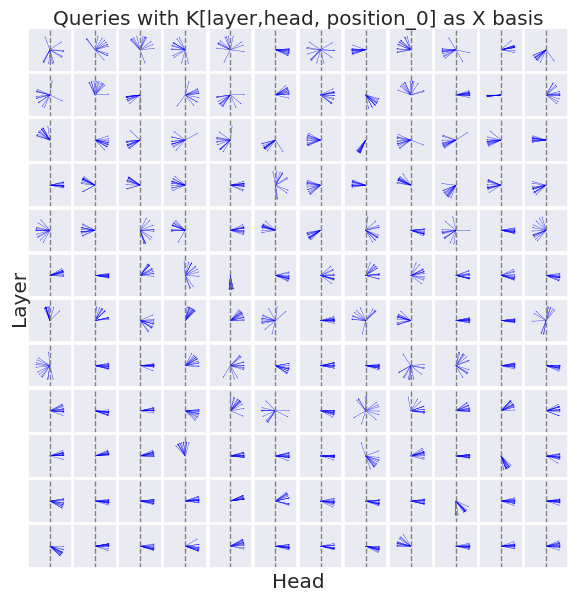

In [ ]:
qs = []
ks = []
def hook(activation, hook: HookPoint):
  if hook.name.endswith("hook_k"):
    ks.append(activation[0, 0, :, :].detach().numpy())
  else:
    qs.append(activation[0, :, :, :].detach().numpy())
filter = lambda name: name.endswith(f"attn.hook_q") or name.endswith(f"attn.hook_k")
model.run_with_hooks(
    [SHORT_PROMPT],
    return_type=None,
    fwd_hooks=[(filter, hook)],
)

rows, cols = model.cfg.n_layers, model.cfg.n_heads
fig, axs = plt.subplots(rows, cols, figsize=(6,6))

for layer in range(model.cfg.n_layers):
  for head in range(model.cfg.n_heads):
    k = ks[layer][head]
    R_hd = rotation_matrix_to_first_axis_nd(k)
    rotated_k = R_hd @ k
    rotated_k_2d = [rotated_k[0],rotated_k[1]]

    rotated_qs_2d = []
    qs_at_pos = qs[layer][1:,head]
    for q in qs_at_pos:
      rotated_q = R_hd @ q
      q1, q2 = rotated_q[0], rotated_q[1]
      norm = (q1**2+q2**2)**0.5
      rotated_qs_2d.append([q1/norm, q2/norm])
    plot_2d_vectors_in_subplot(rotated_qs_2d, layer, head, model.cfg.n_layers, model.cfg.n_heads, fig=fig, axs=axs)

plt.tight_layout(pad=0.1)
fig.subplots_adjust(top=0.95, left=0.05, bottom=0.05, right=0.95)
fig.suptitle('Queries with K[layer,head, position_0] as X basis')
fig.supxlabel('Head')
fig.supylabel('Layer')
plt.show()

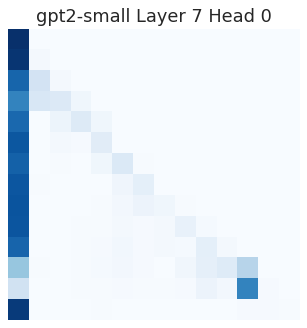

In [ ]:
#consider layer 7 head 0.. what is going on with this attention pattern.
layer_view = 7
head=0

acts = []
def hook(activation, hook: HookPoint):
    acts.append(activation[0].detach().numpy())
filter = lambda name: name.endswith("attn.hook_pattern")
model.run_with_hooks(
    [SHORT_PROMPT],
    return_type=None,
    fwd_hooks=[(filter, hook)],
)

num_heads = acts[layer_view].shape[0]
n_rows = (num_heads + 2) // 4
fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi=80)

im = ax.imshow(acts[layer_view][head], aspect='auto', cmap='Blues', vmin=0, vmax=1)
ax.axis('off')

plt.tight_layout()
fig.suptitle(f"{MODEL_NAME} Layer {layer_view} Head {head}", fontsize=16, y=1.02)
plt.show()

In [ ]:
activations = {}
layer = 7
head=0
def hook(activation, hook: HookPoint):
    activations[hook.name] = activation[0].detach().numpy()
hook_names = [f'blocks.{layer}.ln1.hook_normalized',f'blocks.{layer}.attn.hook_k',f'blocks.{layer}.attn.hook_q',f'blocks.{layer}.attn.hook_pattern']
filter = lambda name: name in hook_names
model.run_with_hooks(
    [SHORT_PROMPT],
    return_type=None,
    fwd_hooks=[(filter, hook)],
)

param_dict = {}
params = [f'blocks.{layer}.attn.W_K',f'blocks.{layer}.attn.b_K']
for n,v in model.named_parameters():
  if n in params:
    param_dict[n]=v.detach().numpy()

attn = activations[f'blocks.{layer}.attn.hook_pattern'][head]
attn[:,0]=-1000000000
max_pos = np.argmax(attn, axis=1)
max_keys = activations[f'blocks.{layer}.attn.hook_k'][max_pos,head,:]

w_iso = np.zeros(param_dict[f'blocks.{layer}.attn.W_K'][head].shape)
w_iso[MASSIVE_ACT_DIM] = param_dict[f'blocks.{layer}.attn.W_K'][head, MASSIVE_ACT_DIM]

k1 = activations[f'blocks.{layer}.attn.hook_k'][0,head]
k2 = activations[f'blocks.{layer}.ln1.hook_normalized'][0]@param_dict[f'blocks.{layer}.attn.W_K'][head]
k3 = activations[f'blocks.{layer}.ln1.hook_normalized'][0]@w_iso
q = activations[f'blocks.{layer}.attn.hook_q'][:,head,:]
out1 = q@k1
out2 = q@k2
out3 = q@k3
out4 = np.array([sum(max_keys[i]*q[i])  for i in range(q.shape[0])])
df = pd.DataFrame({'k':out1, 'k_no_bias':out2, f'k_W[{MASSIVE_ACT_DIM}]':out3, 'max_alt':out4})
df['k.'] = np.linalg.norm(k1)
df['k_no_bias.'] = np.linalg.norm(k2)
df[f'k_W[{MASSIVE_ACT_DIM}].'] = np.linalg.norm(k3)
df['max_alt.'] = np.linalg.norm(max_keys,axis=1)
df = df[['k.','k_no_bias.',f'k_W[{MASSIVE_ACT_DIM}].','max_alt.','k','k_no_bias',f'k_W[{MASSIVE_ACT_DIM}]','max_alt']]
new_header = [('l2_norm', 'k.'), ('l2_norm', 'k_no_bias.'), ('l2_norm', f'k_W[{MASSIVE_ACT_DIM}].'), ('l2_norm', 'max_alt.'),
 ('attn_logit when using..', 'k'), ('attn_logit when using..', 'k_no_bias'), ('attn_logit when using..', f'k_W[{MASSIVE_ACT_DIM}]'), ('attn_logit', 'max_alt')]
df.columns = pd.MultiIndex.from_tuples(new_header)
df

l2_norm                                 attn_logit when using..  \
          k. k_no_bias. k_W[447].   max_alt.                       k   
0   4.665101   4.394004  2.709284  18.766872                5.074090   
1   4.665101   4.394004  2.709284  18.766872                0.929986   
2   4.665101   4.394004  2.709284  18.766872               -0.580103   
3   4.665101   4.394004  2.709284  18.766872               -0.384348   
4   4.665101   4.394004  2.709284  20.023663               -4.160346   
5   4.665101   4.394004  2.709284  20.346226               -3.494534   
6   4.665101   4.394004  2.709284  21.269098               -4.359537   
7   4.665101   4.394004  2.709284  22.540648               -6.064484   
8   4.665101   4.394004  2.709284  22.540648               -5.253182   
9   4.665101   4.394004  2.709284  23.475180               -7.435276   
10  4.665101   4.394004  2.709284  23.845926               -5.655227   
11  4.665101   4.394004  2.709284  21.466150              -10.775951   
12  4.665101   4.394004  2.709284  21.466150               -7.198583   
13  4.665101   4.394004  2.709284  21.466150               -0.138193   

                         attn_logit  
    k_no_bias   k_W[447]    max_alt  
0    3.193357   1.566167   2.617717  
1   17.619587  11.586490 -29.123695  
2   13.762035   8.186400 -12.319330  
3   17.618519  10.613557 -12.300801  
4   12.373792   7.275840 -18.832441  
5   14.452998   9.008674 -19.770907  
6   15.410643   9.904238 -18.460895  
7   15.143864   9.237240 -23.984391  
8   12.322467   6.755221 -27.025954  
9   10.398384   6.167152 -27.118734  
10  13.977606   8.552048 -22.830389  
11   8.277708   5.334793 -13.032966  
12  12.760696   7.854184   3.022986  
13  18.363487  10.974414 -35.974352

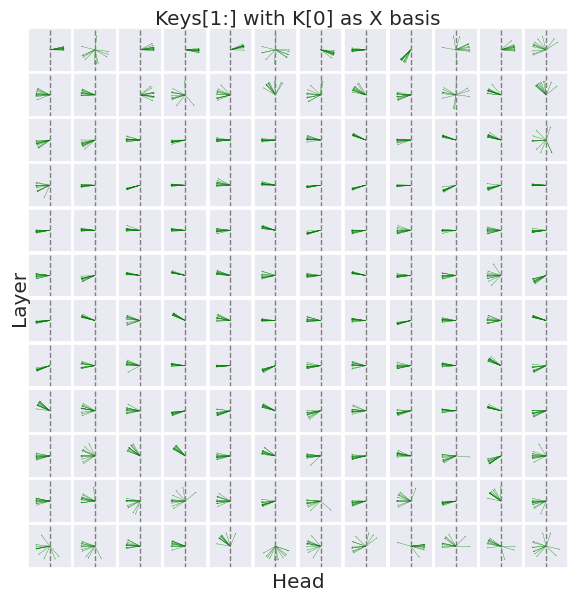

In [ ]:
ks_other = []
ks = []
def hook(activation, hook: HookPoint):
  if hook.name.endswith("hook_k"):
    ks.append(activation[0, 0, :, :].detach().numpy())
    ks_other.append(activation[0, 1:, :, :].detach().numpy())
filter = lambda name: name.endswith(f"attn.hook_k")
model.run_with_hooks(
    [SHORT_PROMPT],
    return_type=None,
    fwd_hooks=[(filter, hook)],
)

rows, cols = model.cfg.n_layers, model.cfg.n_heads
fig, axs = plt.subplots(rows, cols, figsize=(6,6))

for layer in range(model.cfg.n_layers):
  for head in range(model.cfg.n_heads):
    k = get_param(f'blocks.{layer}.attn.W_K')[head,MASSIVE_ACT_DIM]
    R_hd = rotation_matrix_to_first_axis_nd(k)
    rotated_k = R_hd @ k
    rotated_k_2d = [rotated_k[0],rotated_k[1]]

    rotated_ko_2d = []
    ko_at_pos = ks_other[layer][1:,head]
    for ko in ko_at_pos:
      rotated_ko = R_hd @ ko
      ko1, ko2 = rotated_ko[0], rotated_ko[1]
      norm = (ko1**2+ko2**2)**0.5
      rotated_ko_2d.append([ko1/norm, ko2/norm])
    plot_2d_vectors_in_subplot(rotated_ko_2d, layer, head, model.cfg.n_layers, model.cfg.n_heads, fig=fig, axs=axs, color='green')

plt.tight_layout(pad=0.1)
fig.subplots_adjust(top=0.95, left=0.05, bottom=0.05, right=0.95)
fig.suptitle(f'Keys[1:] with K[0] as X basis')
fig.supxlabel('Head')
fig.supylabel('Layer')
plt.show()

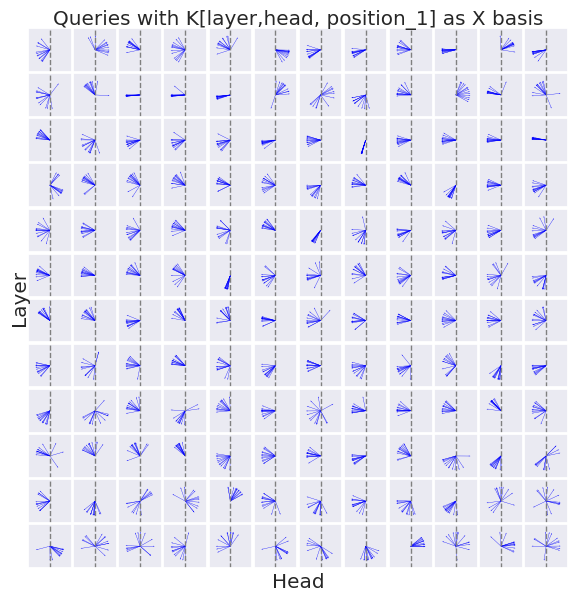

In [ ]:
qs = []
ks = []
def hook(activation, hook: HookPoint):
  if hook.name.endswith("hook_k"):
    ks.append(activation[0, 1, :, :].detach().numpy())
  else:
    qs.append(activation[0, :, :, :].detach().numpy())
filter = lambda name: name.endswith(f"attn.hook_q") or name.endswith(f"attn.hook_k")
model.run_with_hooks(
    [SHORT_PROMPT],
    return_type=None,
    fwd_hooks=[(filter, hook)],
)

rows, cols = model.cfg.n_layers, model.cfg.n_heads
fig, axs = plt.subplots(rows, cols, figsize=(6,6))

for layer in range(model.cfg.n_layers):
  for head in range(model.cfg.n_heads):
    k = ks[layer][head]
    R_hd = rotation_matrix_to_first_axis_nd(k)
    rotated_k = R_hd @ k
    rotated_k_2d = [rotated_k[0],rotated_k[1]]

    rotated_qs_2d = []
    qs_at_pos = qs[layer][1:,head]
    for q in qs_at_pos:
      rotated_q = R_hd @ q
      q1, q2 = rotated_q[0], rotated_q[1]
      norm = (q1**2+q2**2)**0.5
      rotated_qs_2d.append([q1/norm, q2/norm])
    plot_2d_vectors_in_subplot(rotated_qs_2d, layer, head, model.cfg.n_layers, model.cfg.n_heads, fig=fig, axs=axs)

plt.tight_layout(pad=0.1)
fig.subplots_adjust(top=0.95, left=0.05, bottom=0.05, right=0.95)
fig.suptitle('Queries with K[layer,head, position_1] as X basis')
fig.supxlabel('Head')
fig.supylabel('Layer')
plt.show()

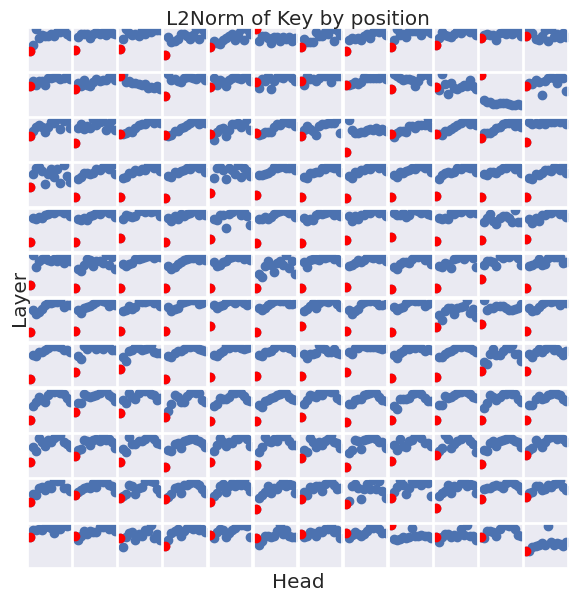

In [ ]:
def plot_in_subplot(vectors, row, col, rows, cols, fig=None, axs=None, colors=None):
    ax = axs[row][col]
    ax.plot(vectors,'o')
    ax.plot(vectors[0:1],'o',color='red')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_ylim(bottom=0)
    return fig, axs

#check the magnitude of the key.., and how it compares to the magnitudes of the other keys.
ks = []
def hook(activation, hook: HookPoint):
  ks.append(activation[0, :, :, :].detach().numpy())
filter = lambda name: name.endswith(f"attn.hook_k")
model.run_with_hooks(
    [SHORT_PROMPT],
    return_type=None,
    fwd_hooks=[(filter, hook)],
)
#for each layer and head, plot the magnitude of the bos_k and the magnitude of the other keys
rows, cols = model.cfg.n_layers, model.cfg.n_heads
fig, axs = plt.subplots(rows, cols, figsize=(6,6))

mags = []
for layer, layer_ks in enumerate(ks):
  for head in range(model.cfg.n_heads):
    mags = []
    for pos in range(layer_ks.shape[0]):
      mags.append(np.linalg.norm(layer_ks[pos,head]))
    plot_in_subplot(mags, layer, head, model.cfg.n_layers, model.cfg.n_heads, fig=fig, axs=axs)
plt.tight_layout(pad=0.1)
fig.subplots_adjust(top=0.95, left=0.05, bottom=0.05, right=0.95)
fig.suptitle('L2Norm of Key by position')
fig.supxlabel('Head')
fig.supylabel('Layer')
plt.show()

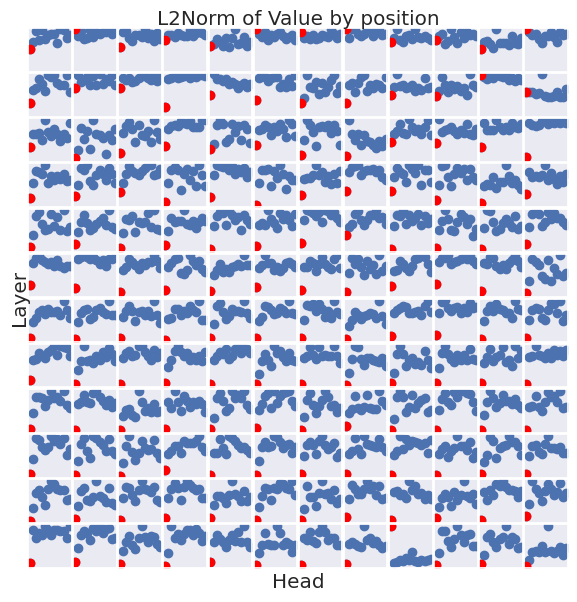

In [ ]:
ks = []
def hook(activation, hook: HookPoint):
  ks.append(activation[0, :, :, :].detach().numpy())
filter = lambda name: name.endswith(f"attn.hook_v")
model.run_with_hooks(
    [SHORT_PROMPT],
    return_type=None,
    fwd_hooks=[(filter, hook)],
)
rows, cols = model.cfg.n_layers, model.cfg.n_heads
fig, axs = plt.subplots(rows, cols, figsize=(6,6))

mags = []
for layer, layer_ks in enumerate(ks):
  for head in range(model.cfg.n_heads):
    mags = []
    for pos in range(layer_ks.shape[0]):
      mags.append(np.linalg.norm(layer_ks[pos,head]))
    plot_in_subplot(mags, layer, head, model.cfg.n_layers, model.cfg.n_heads, fig=fig, axs=axs)
plt.tight_layout(pad=0.1)
fig.subplots_adjust(top=0.95, left=0.05, bottom=0.05, right=0.95)
fig.suptitle('L2Norm of Value by position')
fig.supxlabel('Head')
fig.supylabel('Layer')
plt.show()

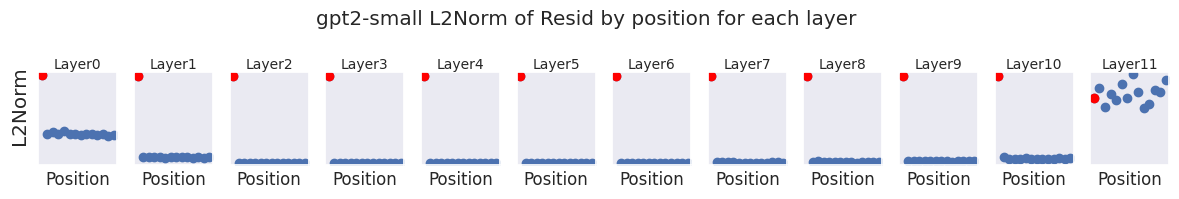

In [ ]:
#why is this done by a sparse residual stream? Couldn't be still shift queries towards any arbitrary key from a dense residual stream?
def plot_in_subplot_1d(vectors, col, cols, fig=None, axs=None, colors=None):
    ax = axs[col]
    ax.plot(vectors,'o')
    ax.plot(vectors[0:1],'o',color='red')
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.set_xticklabels([])
    ax.set_xlabel('Position')
    ax.set_yticklabels([])
    ax.set_ylim(bottom=0)
    ax.set_title(f"Layer{col}", fontsize=10, pad=2)
    return fig, axs

ks = []
def hook(activation, hook: HookPoint):
  ks.append(activation[0].detach().numpy())
filter = lambda name: name.endswith(f"resid_post")

model.run_with_hooks(
    [SHORT_PROMPT],
    return_type=None,
    fwd_hooks=[(filter, hook)],
)

rows=model.cfg.n_layers
fig, axs = plt.subplots(1,rows, figsize=(12,2))
mags = []
for layer, layer_ks in enumerate(ks):
    mags = []
    for pos in range(layer_ks.shape[0]):
      mags.append(np.linalg.norm(layer_ks[pos]))
    plot_in_subplot_1d(mags, layer, model.cfg.n_layers, fig=fig, axs=axs)
fig.suptitle(f'{MODEL_NAME} L2Norm of Resid by position for each layer')

fig.supylabel('L2Norm')
fig.subplots_adjust(top=0.95, left=0.2, bottom=0.2, right=0.95)
plt.tight_layout(pad=1)
plt.show()

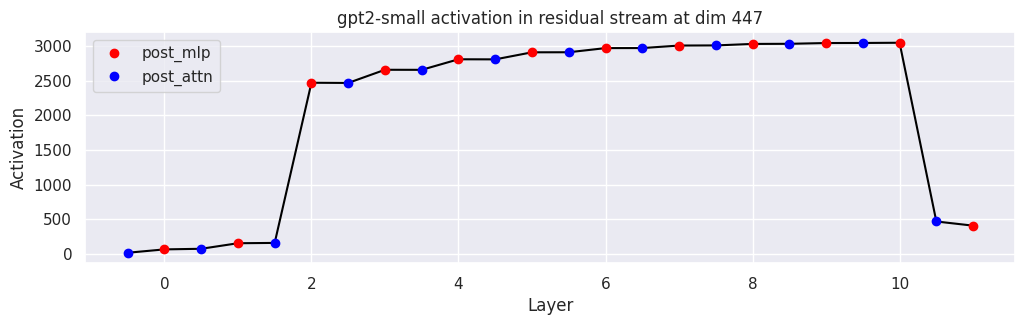

In [ ]:
#show how the residual stream activation changes by layer.
post_mlp = []
post_att = []
def hook(activation, hook: HookPoint):
    if hook.name.endswith('resid_post'):
      post_mlp.append(activation[0][0,MASSIVE_ACT_DIM].detach().item())
    else:
      post_att.append(activation[0][0,MASSIVE_ACT_DIM].detach().item())
filter = lambda name: name.endswith("resid_post") or name.endswith("resid_mid")
model.run_with_hooks(
    [SHORT_PROMPT],
    return_type=None,
    fwd_hooks=[(filter, hook)],
)

plt.figure(figsize=(12,3),dpi=100)
mlp_idx = list(range(model.cfg.n_layers))
attn_idx = [x-0.5 for x in mlp_idx]
all_data = []
all_idx = []
for a,b,c,d in zip(post_att, post_mlp, attn_idx, mlp_idx):
  all_data.append(a)
  all_data.append(b)
  all_idx.append(c)
  all_idx.append(d)
plt.plot(all_idx, all_data, color='black')

plt.plot(mlp_idx,post_mlp, 'o',color='red',label='post_mlp')
plt.plot(attn_idx,post_att, 'o',color='blue',label='post_attn')

plt.legend()
plt.title(f'{MODEL_NAME} activation in residual stream at dim {MASSIVE_ACT_DIM}')
plt.xlabel('Layer')
plt.ylabel('Activation')
plt.show()

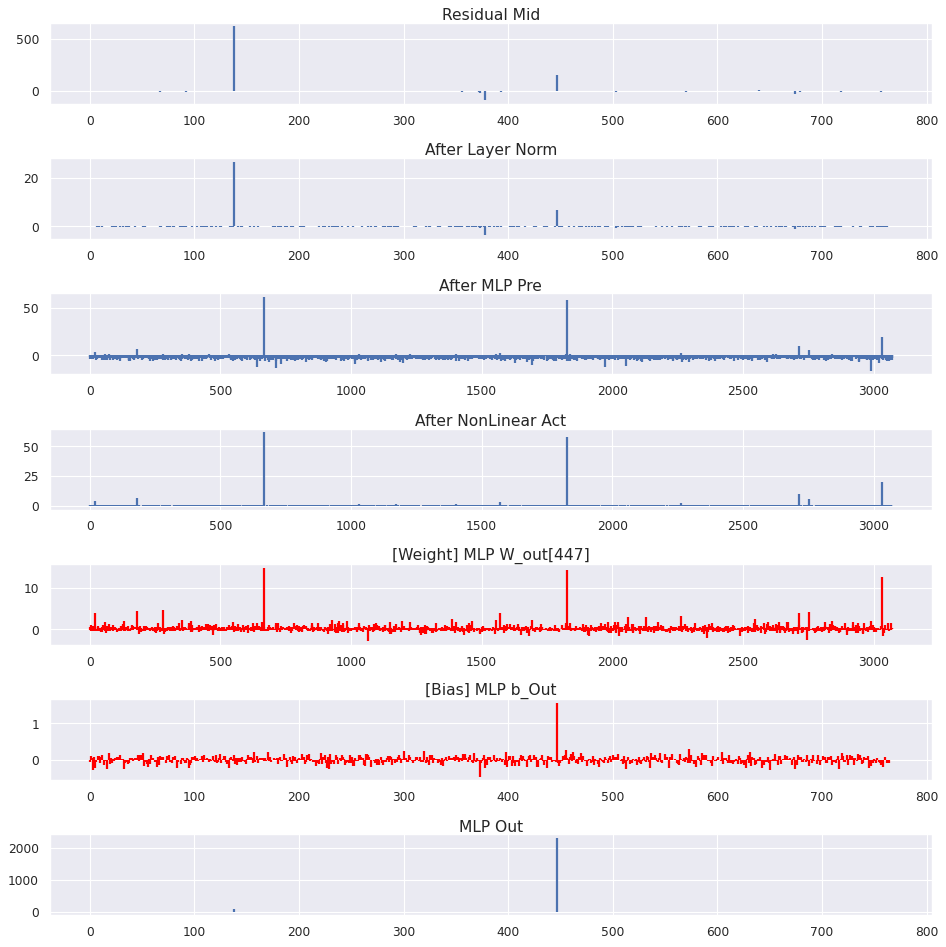

In [ ]:
#show how the residual stream activation changes by layer.
activations = {}
def hook(activation, hook: HookPoint):
    activations[hook.name] = activation[0,0].detach().numpy()
hook_names = ['blocks.2.hook_resid_mid','blocks.2.ln2.hook_normalized','blocks.2.mlp.hook_pre','blocks.2.mlp.hook_post','blocks.2.hook_mlp_out']
filter = lambda name: name in hook_names
model.run_with_hooks(
    [SHORT_PROMPT],
    return_type=None,
    fwd_hooks=[(filter, hook)],
)

param_dict = {}
params = ['blocks.2.mlp.W_in','blocks.2.mlp.b_in','blocks.2.mlp.W_out','blocks.2.mlp.b_out']
for n,v in model.named_parameters():
  if n in params:
    param_dict[n]=v.detach().numpy()

fig, axes = plt.subplots(7, figsize=(12, 12), dpi=80)

axes[0].vlines(x=list(range(len(activations['blocks.2.hook_resid_mid']))), ymin=0, ymax=activations['blocks.2.hook_resid_mid'], linewidth=2)
axes[0].set_title(f"Residual Mid", fontsize=14, pad=2)

axes[1].vlines(x=list(range(len(activations['blocks.2.ln2.hook_normalized']))), ymin=0, ymax=activations['blocks.2.ln2.hook_normalized'], linewidth=2)
axes[1].set_title(f"After Layer Norm", fontsize=14, pad=2)

axes[2].vlines(x=list(range(len(activations['blocks.2.mlp.hook_pre']))), ymin=0, ymax=activations['blocks.2.mlp.hook_pre'], linewidth=2)
axes[2].set_title(f"After MLP Pre", fontsize=14, pad=2)

axes[3].vlines(x=list(range(len(activations['blocks.2.mlp.hook_post']))), ymin=0, ymax=activations['blocks.2.mlp.hook_post'], linewidth=2)
axes[3].set_title(f"After NonLinear Act", fontsize=14, pad=2)

axes[4].vlines(x=list(range(len(param_dict['blocks.2.mlp.W_out'][:,MASSIVE_ACT_DIM]))), color='red',ymin=0, ymax=param_dict['blocks.2.mlp.W_out'][:,MASSIVE_ACT_DIM], linewidth=2)
axes[4].set_title(f"[Weight] MLP W_out[{MASSIVE_ACT_DIM}]", fontsize=14, pad=2)

axes[5].vlines(x=list(range(len(param_dict['blocks.2.mlp.b_out'][:]))), color='red',ymin=0, ymax=param_dict['blocks.2.mlp.b_out'][:], linewidth=2)
axes[5].set_title(f"[Bias] MLP b_Out", fontsize=14, pad=2)

axes[6].vlines(x=list(range(len(activations['blocks.2.hook_mlp_out']))), ymin=0, ymax=activations['blocks.2.hook_mlp_out'], linewidth=2)
axes[6].set_title(f"MLP Out", fontsize=14, pad=2)

plt.tight_layout()
plt.show()


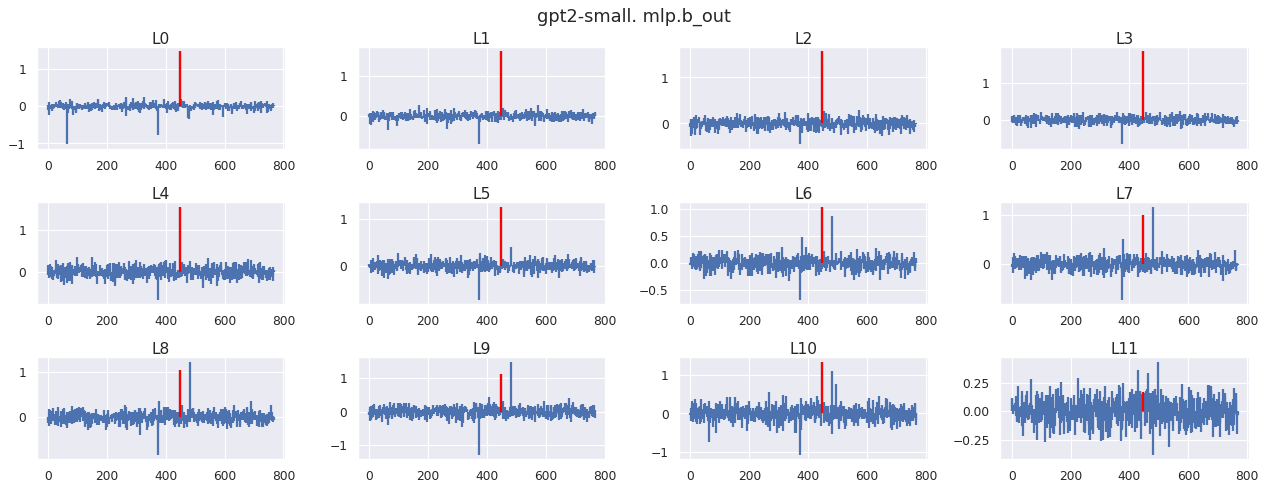

In [ ]:
params = []
param = 'mlp.b_out'
for n,v in model.named_parameters():
  if n.endswith(param):
    params.append(v.detach().numpy())

fig, axes = plt.subplots(3,4, figsize=(16,6), dpi=80)
axes = axes.flatten()
x = list(range(len(params[0])))
for idx, p in enumerate(params):
  axes[idx].vlines(x=x, ymin=0, ymax=p, linewidth=2)
  axes[idx].vlines(x=x[MASSIVE_ACT_DIM], ymin=0, ymax=p[MASSIVE_ACT_DIM], linewidth=2,color='red')
  axes[idx].set_title(f"L{idx}", fontsize=14, pad=2)

plt.tight_layout()
fig.suptitle(f"{MODEL_NAME}. mlp.b_out", fontsize=16, y=1.02)
plt.show()

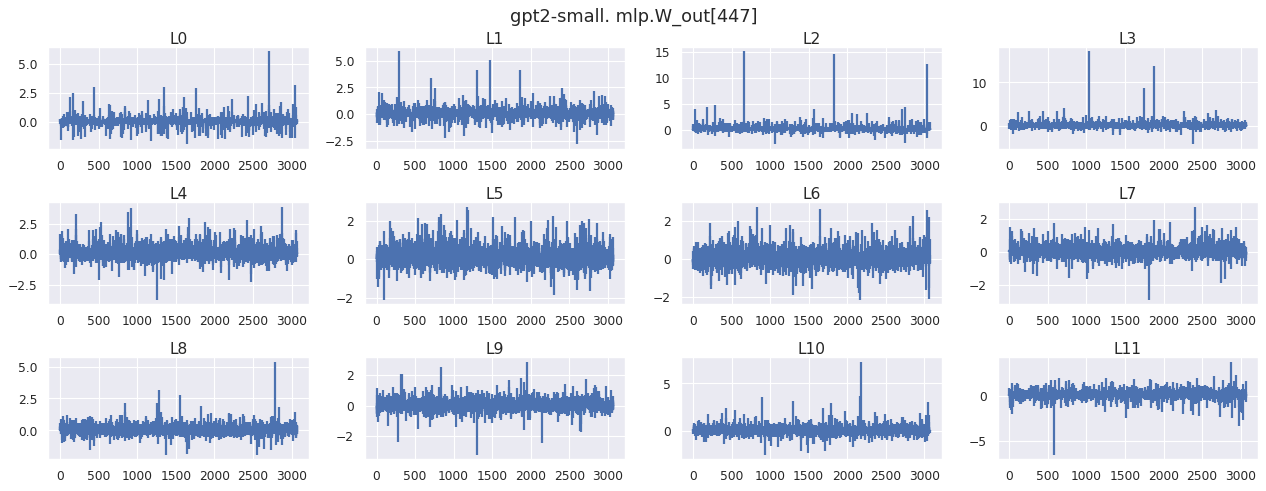

In [ ]:
params = []
param = 'mlp.W_out'
for n,v in model.named_parameters():
  if n.endswith(param):
    params.append(v[:,MASSIVE_ACT_DIM].detach().numpy())

fig, axes = plt.subplots(3,4, figsize=(16,6), dpi=80)
axes = axes.flatten()
x = list(range(len(params[0])))
for idx, p in enumerate(params):
  axes[idx].vlines(x=x, ymin=0, ymax=p, linewidth=2)
  axes[idx].set_title(f"L{idx}", fontsize=14, pad=2)

plt.tight_layout()
fig.suptitle(f"{MODEL_NAME}. mlp.W_out[{MASSIVE_ACT_DIM}]", fontsize=16, y=1.02)
plt.show()

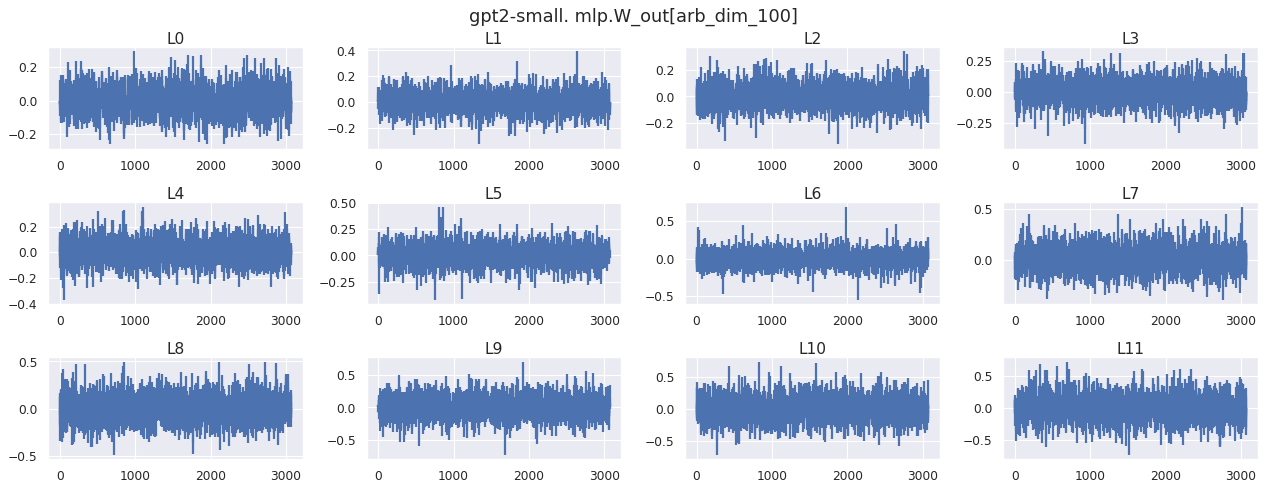

In [ ]:
params = []
param = 'mlp.W_out'
for n,v in model.named_parameters():
  if n.endswith(param):
    params.append(v[:,100].detach().numpy())

fig, axes = plt.subplots(3,4, figsize=(16,6), dpi=80)
axes = axes.flatten()
x = list(range(len(params[0])))
for idx, p in enumerate(params):
  axes[idx].vlines(x=x, ymin=0, ymax=p, linewidth=2)
  axes[idx].set_title(f"L{idx}", fontsize=14, pad=2)

plt.tight_layout()
fig.suptitle(f"{MODEL_NAME}. mlp.W_out[arb_dim_100]", fontsize=16, y=1.02)
plt.show()

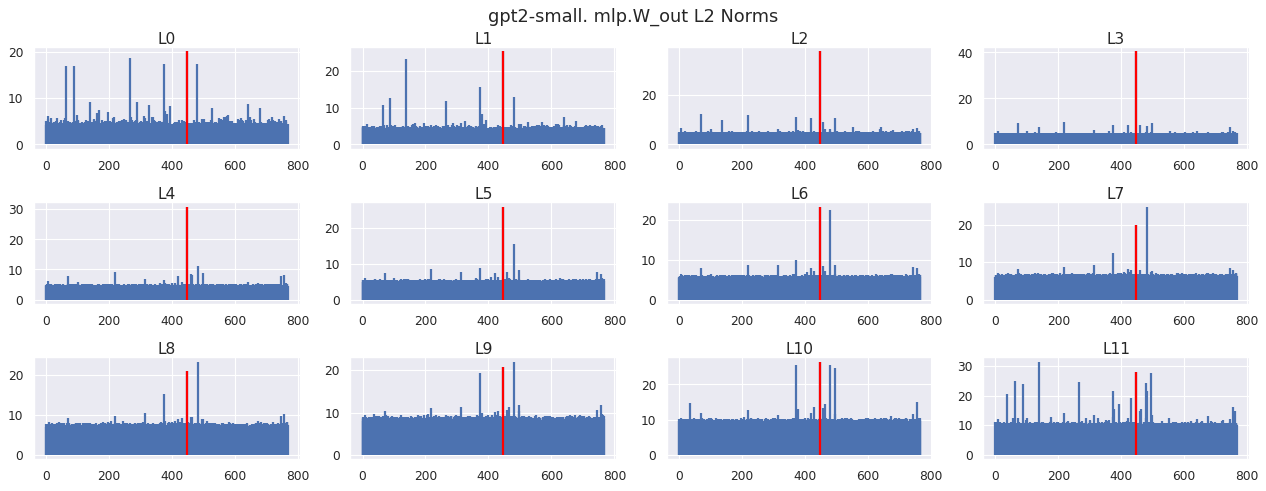

In [ ]:
#look at the norms of each dimension in W
params = []
param = 'mlp.W_out'
for n,v in model.named_parameters():
  if n.endswith(param):
    params.append(v.detach().numpy())
params[0].shape
fig, axes = plt.subplots(3,4, figsize=(16,6), dpi=80)
axes = axes.flatten()
x = list(range(params[0].shape[1]))
for idx, p in enumerate(params):
  axes[idx].vlines(x=x, ymin=0, ymax=np.linalg.norm(p, axis=0), linewidth=2)
  axes[idx].vlines(x=x[MASSIVE_ACT_DIM], ymin=0, ymax=np.linalg.norm(p, axis=0)[MASSIVE_ACT_DIM], linewidth=2, color='red')
  axes[idx].set_title(f"L{idx}", fontsize=14, pad=2)

plt.tight_layout()
fig.suptitle(f"{MODEL_NAME}. mlp.W_out L2 Norms", fontsize=16, y=1.02)
plt.show()

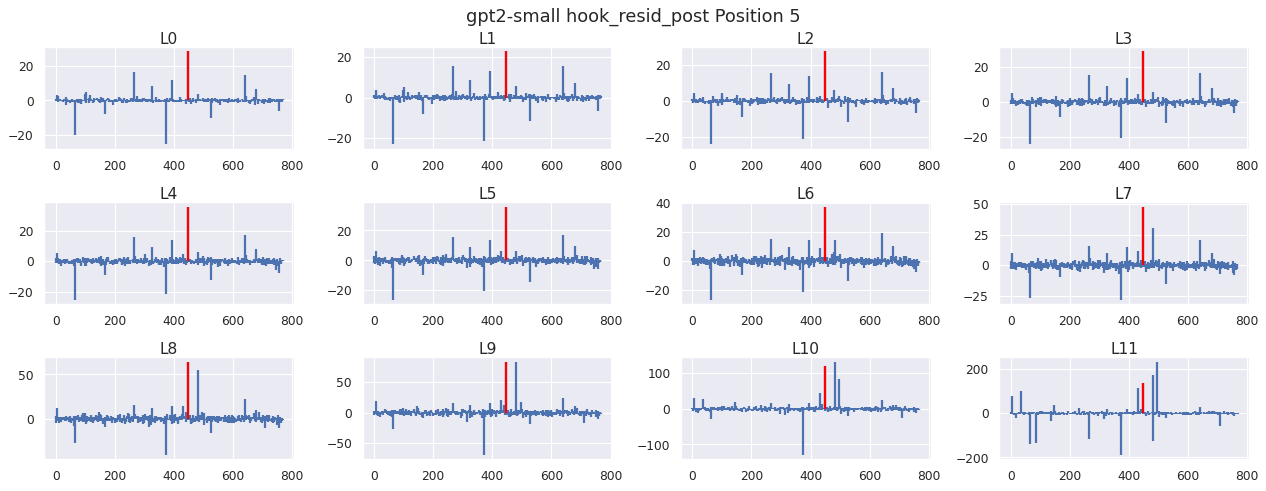

In [ ]:
#are there side effects on other positions residual stream?
#load the params.
#show how the residual stream activation changes by layer.
activations = []
position=5
def hook(activation, hook: HookPoint):
    activations.append(activation[0][position].detach().numpy())
hook_name ='hook_resid_post'
filter = lambda name: name.endswith(hook_name)
model.run_with_hooks(
    [SHORT_PROMPT],
    return_type=None,
    fwd_hooks=[(filter, hook)],
)

fig, axes = plt.subplots(3,4, figsize=(16,6), dpi=80)
axes = axes.flatten()
x = list(range(len(activations[0])))
for idx, a in enumerate(activations):
  axes[idx].vlines(x=x, ymin=0, ymax=a, linewidth=2)
  axes[idx].vlines(x=x[MASSIVE_ACT_DIM], ymin=0, ymax=a[MASSIVE_ACT_DIM], linewidth=2, color='red')
  axes[idx].set_title(f"L{idx}", fontsize=14, pad=2)
plt.tight_layout()
fig.suptitle(f"{MODEL_NAME} hook_resid_post Position 5", fontsize=16, y=1.02)
plt.show()

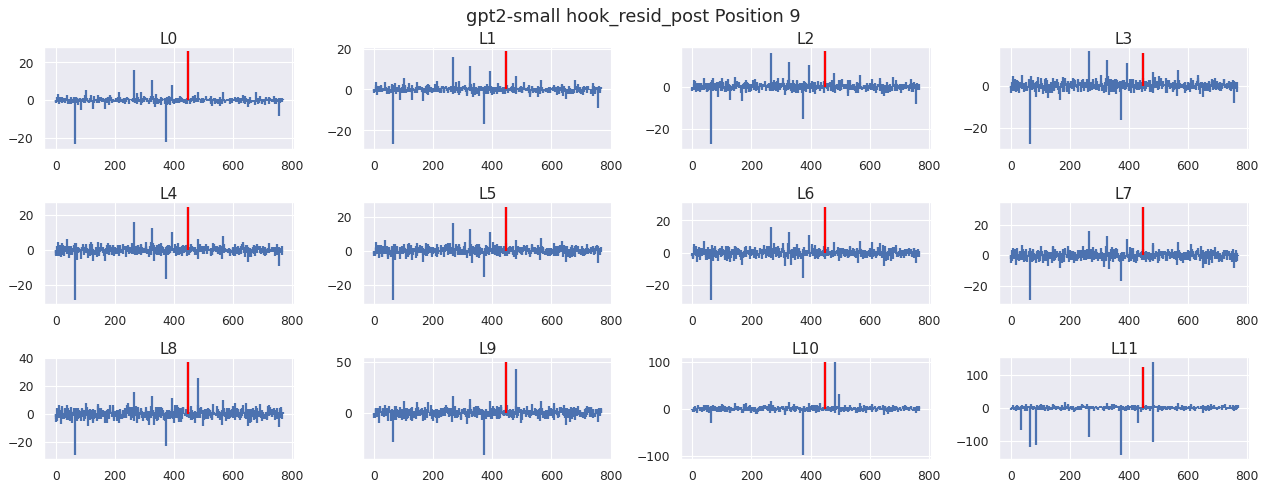

In [ ]:
#are there side effects on other positions residual stream?
#load the params.
#show how the residual stream activation changes by layer.
activations = []
position=9
def hook(activation, hook: HookPoint):
    activations.append(activation[0][position].detach().numpy())
hook_name ='hook_resid_post'
filter = lambda name: name.endswith(hook_name)
model.run_with_hooks(
    [SHORT_PROMPT],
    return_type=None,
    fwd_hooks=[(filter, hook)],
)

fig, axes = plt.subplots(3,4, figsize=(16,6), dpi=80)
axes = axes.flatten()
x = list(range(len(activations[0])))
for idx, a in enumerate(activations):
  axes[idx].vlines(x=x, ymin=0, ymax=a, linewidth=2)
  axes[idx].vlines(x=x[MASSIVE_ACT_DIM], ymin=0, ymax=a[MASSIVE_ACT_DIM], linewidth=2, color='red')
  axes[idx].set_title(f"L{idx}", fontsize=14, pad=2)
plt.tight_layout()
fig.suptitle(f"{MODEL_NAME} hook_resid_post Position 9", fontsize=16, y=1.02)
plt.show()

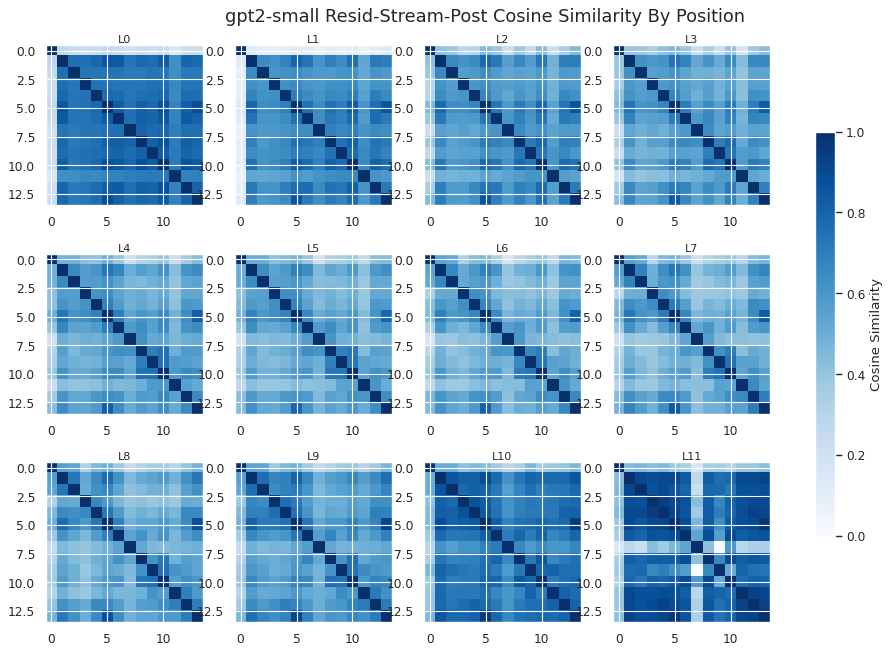

In [ ]:
#what is going on here?
#its like the residual streams have convered to the same value at every position...
#get the cosin similarity between every position and eveyr other position at each layer.
#so I will have a 2d plot for each layer.

#are there side effects on other positions residual stream?
#load the params.
#show how the residual stream activation changes by layer.
def sim(x,y):
  return sum(x*y)/np.linalg.norm(x)/np.linalg.norm(y)

activations = []
def hook(activation, hook: HookPoint):
    activations.append(activation[0].detach().numpy())
filter = lambda name: name.endswith('hook_resid_post')
model.run_with_hooks(
    [SHORT_PROMPT],
    return_type=None,
    fwd_hooks=[(filter, hook)],
)

fig, axes = plt.subplots(3, 4, figsize=(12, 8), dpi=80)
axes = axes.flatten()

for idx, layer in enumerate(activations):
  data = []
  for x in range(layer.shape[0]):
    row = []
    for y in range(layer.shape[0]):
      row.append(sim(layer[x],layer[y]))
    data.append(row)
  ax = axes[idx]
  im = ax.imshow(data, aspect='auto', cmap='Blues', vmin=0, vmax=1)
  ax.set_title(f"L{idx}", fontsize=10, pad=2)
plt.tight_layout()
fig.suptitle(f"{MODEL_NAME} Resid-Stream-Post Cosine Similarity By Position", fontsize=16, y=1.02)
fig.colorbar(im, ax=axes, location='right', shrink=0.7, label='Cosine Similarity')
plt.show()

In [ ]:
model.to_str_tokens(SHORT_PROMPT)

['<|endoftext|>',
 'The',
 ' sale',
 ' ends',
 ' today',
 '.',
 ' You',
 ' won',
 "'t",
 ' want',
 ' to',
 ' miss',
 ' it',
 '!']

In [ ]:
tokens = model.to_tokens(SHORT_PROMPT)
logits = model(tokens)
probs = F.softmax(logits, dim=-1)
top_probs, top_indices = probs.topk(5, dim=-1)
decoded_top_preds = [
    [model.to_string(tok.item()) for tok in pos_top]
    for pos_top in top_indices[0]
]

for i, (token, top5) in enumerate(zip(model.to_str_tokens(SHORT_PROMPT), decoded_top_preds)):
    print(f"Position {i} (input: '{token}'): top predictions -> {top5}")

Position 0 (input: '<|endoftext|>'): top predictions -> ['\n', 'The', '"', 'A', 'I']
Position 1 (input: 'The'): top predictions -> [' first', ' U', ' following', ' United', ' US']
Position 2 (input: ' sale'): top predictions -> [' of', ' price', ' is', ' and', ' was']
Position 3 (input: ' ends'): top predictions -> [' on', ' today', ' at', ' this', ' in']
Position 4 (input: ' today'): top predictions -> ['.', ',', ' and', ' at', ' of']
Position 5 (input: '.'): top predictions -> ['\n', ' The', ' We', ' I', '<|endoftext|>']
Position 6 (input: ' You'): top predictions -> [' can', "'ll", ' may', ' will', ' have']
Position 7 (input: ' won'): top predictions -> ["'t", '.', ',', '´', '\n']
Position 8 (input: ''t'): top predictions -> [' be', ' find', ' see', ' get', ' have']
Position 9 (input: ' want'): top predictions -> [' to', ' this', ' it', ' your', ' any']
Position 10 (input: ' to'): top predictions -> [' miss', ' wait', ' go', ' buy', ' be']
Position 11 (input: ' miss'): top predictio

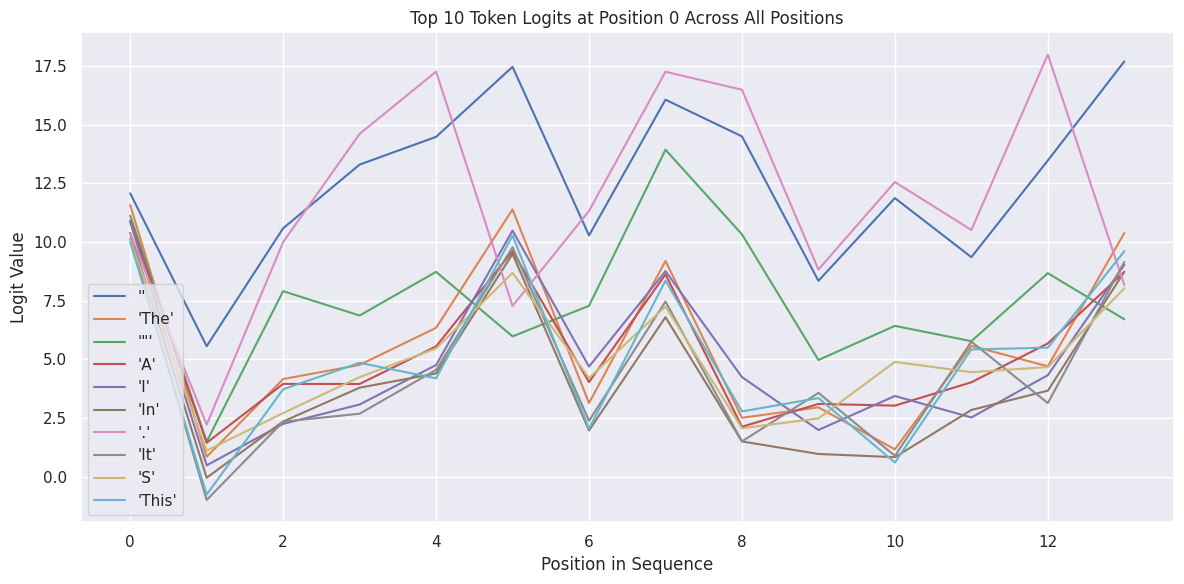

In [ ]:
tokens = model.to_tokens(SHORT_PROMPT)
logits = model(tokens)
# Remove batch dim
logits = logits[0]

# Get top 10 token indices by logit value at position 0
topk_vals, topk_indices = logits[0].topk(10)

# For each of these tokens, collect logits across all positions
logits_over_positions = logits[:, topk_indices]  # shape: (seq_len, 10)

# Plot
plt.figure(figsize=(12, 6))
for i in range(10):
    token_str = model.to_string(topk_indices[i].item()).strip()
    plt.plot(logits_over_positions[:, i].detach().numpy(), label=f"'{token_str}'")

plt.xlabel("Position in Sequence")
plt.ylabel("Logit Value")
plt.title("Top 10 Token Logits at Position 0 Across All Positions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

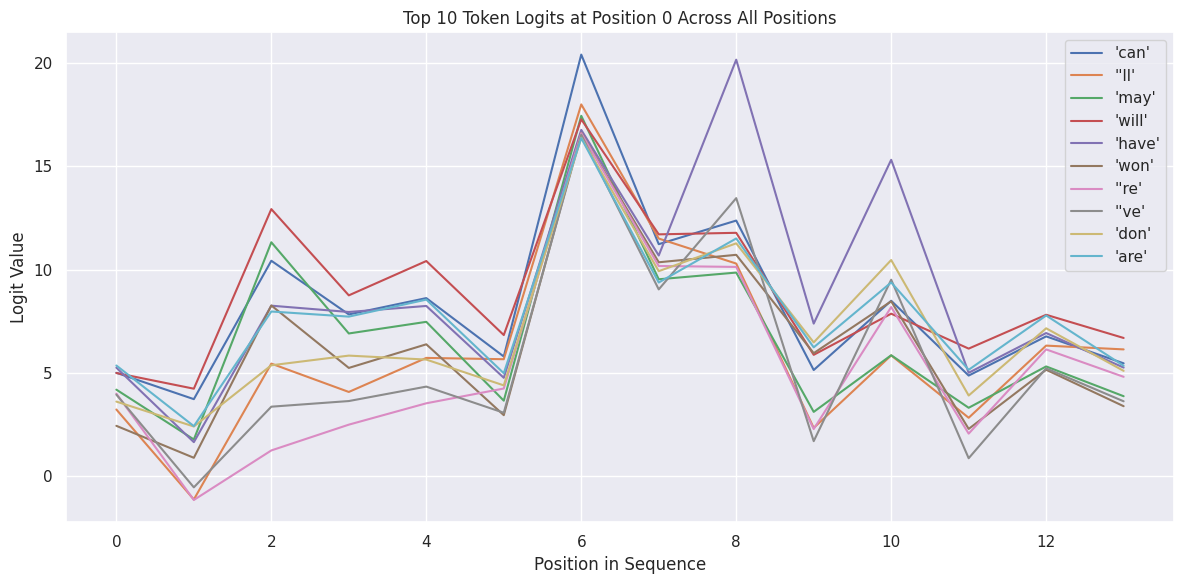

In [ ]:
tokens = model.to_tokens(SHORT_PROMPT)
logits = model(tokens)
# Remove batch dim
logits = logits[0]

# Get top 10 token indices by logit value at position 0
topk_vals, topk_indices = logits[6].topk(10)

# For each of these tokens, collect logits across all positions
logits_over_positions = logits[:, topk_indices]  # shape: (seq_len, 10)

# Plot
plt.figure(figsize=(12, 6))
for i in range(10):
    token_str = model.to_string(topk_indices[i].item()).strip()
    plt.plot(logits_over_positions[:, i].detach().numpy(), label=f"'{token_str}'")

plt.xlabel("Position in Sequence")
plt.ylabel("Logit Value")
plt.title("Top 10 Token Logits at Position 0 Across All Positions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()